# Bibliotecas

In [1]:
import warnings

import numpy        as np
import pandas       as pd
import seaborn      as sns

from typing                 import Literal
from sklearn.linear_model   import LinearRegression
from sklearn.metrics        import r2_score
from ydata_profiling        import ProfileReport

from matplotlib             import pyplot       as plt
from scipy                  import stats        as ss

warnings.filterwarnings( 'ignore' )

c:\Users\mello\anaconda3\envs\ros\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importação de dados

In [2]:
df_03 = pd.read_pickle('../exports/cicle_exports/03_filtering_to_business/df_03.pkl', compression="gzip")

In [3]:
df_04 = df_03.copy()

# Funções

In [4]:
def plot_categorical_distribution(df, variable_col, target_col):
    """
    Plota dois gráficos lado a lado:
    1. Countplot horizontal das categorias da coluna 'variable_col'.
    2. KDEplot das distribuições da coluna 'target_col' para cada categoria de 'variable_col'.

    Parâmetros:
    - df: DataFrame contendo os dados
    - variable_col: string com o nome da coluna categórica
    - target_col: string com o nome da coluna numérica contínua
    """
    # Configuração do estilo dos gráficos
    sns.set(style="whitegrid")
    
    # Criar figura com dois subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Countplot horizontal
    sns.countplot(y=df[variable_col], order=df[variable_col].value_counts().index, ax=axes[0], palette="viridis")
    axes[0].set_title(f'Frequency "{variable_col}"')
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel(variable_col)

    # Gráfico 2: KDEplot da distribuição de 'target_col' para cada categoria
    categories = df[variable_col].dropna().unique()
    for cat in categories:
        sns.kdeplot(
            df[df[variable_col] == cat][target_col].dropna(),
            label=str(cat),
            fill=True,
            ax=axes[1]
        )

    axes[1].set_title(f'Distribution of "{target_col}" by "{variable_col}"')
    axes[1].set_xlabel(target_col)
    axes[1].legend(title=variable_col)
    
    plt.tight_layout()
    plt.show()

In [5]:
def plot_linear_regression(x, y):
    """
    Plota um gráfico de regressão linear entre x e y, incluindo o valor de R² no título.
    A linha de regressão é vermelha e os pontos são menores.
    
    Parâmetros:
    - x: array-like com os dados do eixo X
    - y: array-like com os dados do eixo Y
    """
    x_name = x.name
    y_name = y.name
    # Converter para numpy arrays
    x = np.array(x)
    y = np.array(y)

    # Criar DataFrame
    df = pd.DataFrame({'x': x, 'y': y})

    # Ajustar o modelo de regressão
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    r2 = r2_score(y, model.predict(x.reshape(-1, 1)))

    # Plot com linha vermelha e pontos menores
    sns.lmplot(
        x='x',
        y='y',
        data=df,
        height=6,
        aspect=1.2,
        line_kws={'color': 'red'},         # Linha de regressão vermelha
        scatter_kws={'s': 20}              # Tamanho dos pontos reduzido
    )
    plt.title(f'Linear Regression - R² = {r2:.3f}')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)
    plt.show()

In [6]:
def distribution_comparison(var_1, var_2, label_var_1='var_1', label_var_2='var_2'):
    '''
    Plota dois gráficos de distribuição vapra comparação entre duas variáveis.

    Parâmetros:
        var_1 (pd.Series): Série de dados da primeira variável.
        var_2 (pd.Series): Série de dados da segunda variável.
        label_var_1 (str): Legenda da primeira variável.
        label_var_2 (str): Legenda da segunda variável.
    '''
    plt.figure(figsize=(16, 3))

    plt.subplot( 1, 2, 1 )
    sns.kdeplot(x=var_1, label=label_var_1)
    plt.legend()

    plt.subplot( 1, 2, 2 )
    sns.kdeplot(x=var_2, label=label_var_2)
    plt.legend()

In [7]:
def average_coparison(var_1, 
                      var_2, 
                      type: Literal['independent', 'paired'] = 'independent', 
                      distributon: Literal['normal_distributed', 'non_normal_distributed'] = 'non_normal_distributed', 
                      alfa=0.05, 
                      rounding=2) -> None:
    '''
    Verifica se a diferença entre as médias de duas variáveis é estisticamente significante.

    Parâmetros:
        var_1 (pd.Series): Série de dados da primeira variável.
        var_2 (pd.Series): Série de dados da segunda variável.
        type (str): Se as variáveis são amostras de grupos independendes (independent) ou mesmo grupo medido duas vezes (paired).
        distributon (str): Se uma das variávais NÃO for normalmente distribuida usar 'non_normal_distributed' se ambas forem normais usar 'normal_distributed'
        alfa (float): Valor de alfa para o teste estatístico.
        rounding (int): Arredondamento dos resultados.

    Retorna:
        A média e o desvio padrão das variáveis, o p-valor com uma avaliação se a diferença é ou não estatisticamente significativa 
        e o teste utilizado para validar as hipóteses.
    '''

    # Garantir que sejam arrays numpy
    var_1 = np.array(var_1)
    var_2 = np.array(var_2)

    # Definir teste a ser usado
    if distributon == 'normal_distributed':  # Paramétrico
        if type == 'independent':
            teste_nome = "Student t independent"
            stat, p_val = ss.ttest_ind(var_1, var_2)
        elif type == 'paired':
            teste_nome = "Student r pareado"
            stat, p_val = ss.ttest_rel(var_1, var_2)
        else:
            raise ValueError("Wrong 'type' parameter.")
        
    elif distributon == 'non_normal_distributed':  # Não paramétrico
        if type == 'independent':
            teste_nome = "Mann-Whitney U"
            stat, p_val = ss.mannwhitneyu(var_1, var_2, alternative='two-sided')
        elif type == 'paired':
            teste_nome = "Wilcoxon signed-rank"
            stat, p_val = ss.wilcoxon(var_1, var_2)
        else:
            raise ValueError("Wrong 'type' parameter.")
        
    else:
        raise ValueError("Wrong 'distributon' parameter.")
    
    # Médias e desvios
    avg_1 = round(np.mean(var_1), rounding)
    avg_2 = round(np.mean(var_2), rounding)
    std_1 = round(np.std(var_1), rounding)
    std_2 = round(np.std(var_2), rounding)

    # Significância
    significativa = p_val <= alfa
    resultado = "Statistically significant difference" if significativa else "NOT significant difference"

    # Retornar resultado
    return print (f'Variable 1 - Mean: {avg_1} +/- {std_1}\n'+
                  f'Variable 2 - Mean: {avg_2} +/- {std_2}\n'+
                  f'p-value: {round(p_val, rounding)} -> {resultado}\n'+
                  f'Test: {teste_nome}')

In [8]:
def numeric_correlation_test (x: pd.Series, y: pd.Series, type: Literal['normal_distributed', 'non_normal_distributed'], alfa=0.05, rounding=2) -> None:
    '''
    Calcula a correlação entre duas variáveis e diz se a correlação é estatisticamente significante

    Parâmetros:
        x (pd.Series): Série de dados da primeira variável.
        y (pd.Series): Série de dados da segunda variável.
        type (str): Se as variáveis são normalmente distribuídas (normal_distributed) ou não(non_normal_distributed).
        alfa (float): Valor de alfa para o teste t de Student.
        rounding (int): Arredondamento dos resultados.

    Retorna:
        O valor da correlação com uma medida categórica de sua força e o p-valor com a avaliação se é ou não estatisticamente significante.
    '''

    if type == 'normal_distributed':
        # Pearson corrlation
        r, p_value = ss.pearsonr(x, y)
        test_name = 'Pearson Correlation + Student t'
    elif type == 'non_normal_distributed':
        # Spearman correlation
        r, p_value = ss.spearmanr(x, y)
        test_name = 'Spearman Correlation + Distributed Ranks'

    r_abs = abs(r)
    if r_abs < 0.20:
        strength = "Negligible"
    elif r_abs < 0.40:
        strength = "Week"
    elif r_abs < 0.70:
        strength = "Medium"
    elif r_abs < 0.90:
        strength = "Strong"
    else:
        strength = "Very Strong"

    if p_value < alfa:
        result = 'Correlation is statistically significant'
    else:
        result = 'Correlation is NOT statistically significant'
    
    return print(f'Correlation = {round(r,rounding)} -> {strength}\np-value = {round(p_value,rounding)} - > {result}\nTest: {test_name}')

In [9]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# 4.0. Análise exploratória

## 4.1. Análise univariada

In [10]:
# Selecionando variáveis contínuas (numéricas):
attributes_numeric = df_04[['sales', 
                            'competition_distance', 
                            'competition_time_month',
                            'promo_time_week'
                            ]]

# Selecionando variáveis contínuas temporais (medem o tempo):
atributes_temporal = df_04[['year',
                            'month',
                            'day',
                            'week_of_year',
                            'day_of_week'
                            ]]

# Selecionando variáveis categóricas identificadoras:
attributes_categorical_id = df_04[['store',
                                ]]

# Selecionando variáveis categóricas:
attributes_categorical = df_04[['promo', 
                                'state_holiday', 
                                'school_holiday', 
                                'store_type', 
                                'assortment', 
                                'promo2',
                                'is_promo'
                                ]]

### 4.1.1. Variável resposta

<Axes: xlabel='sales', ylabel='Count'>

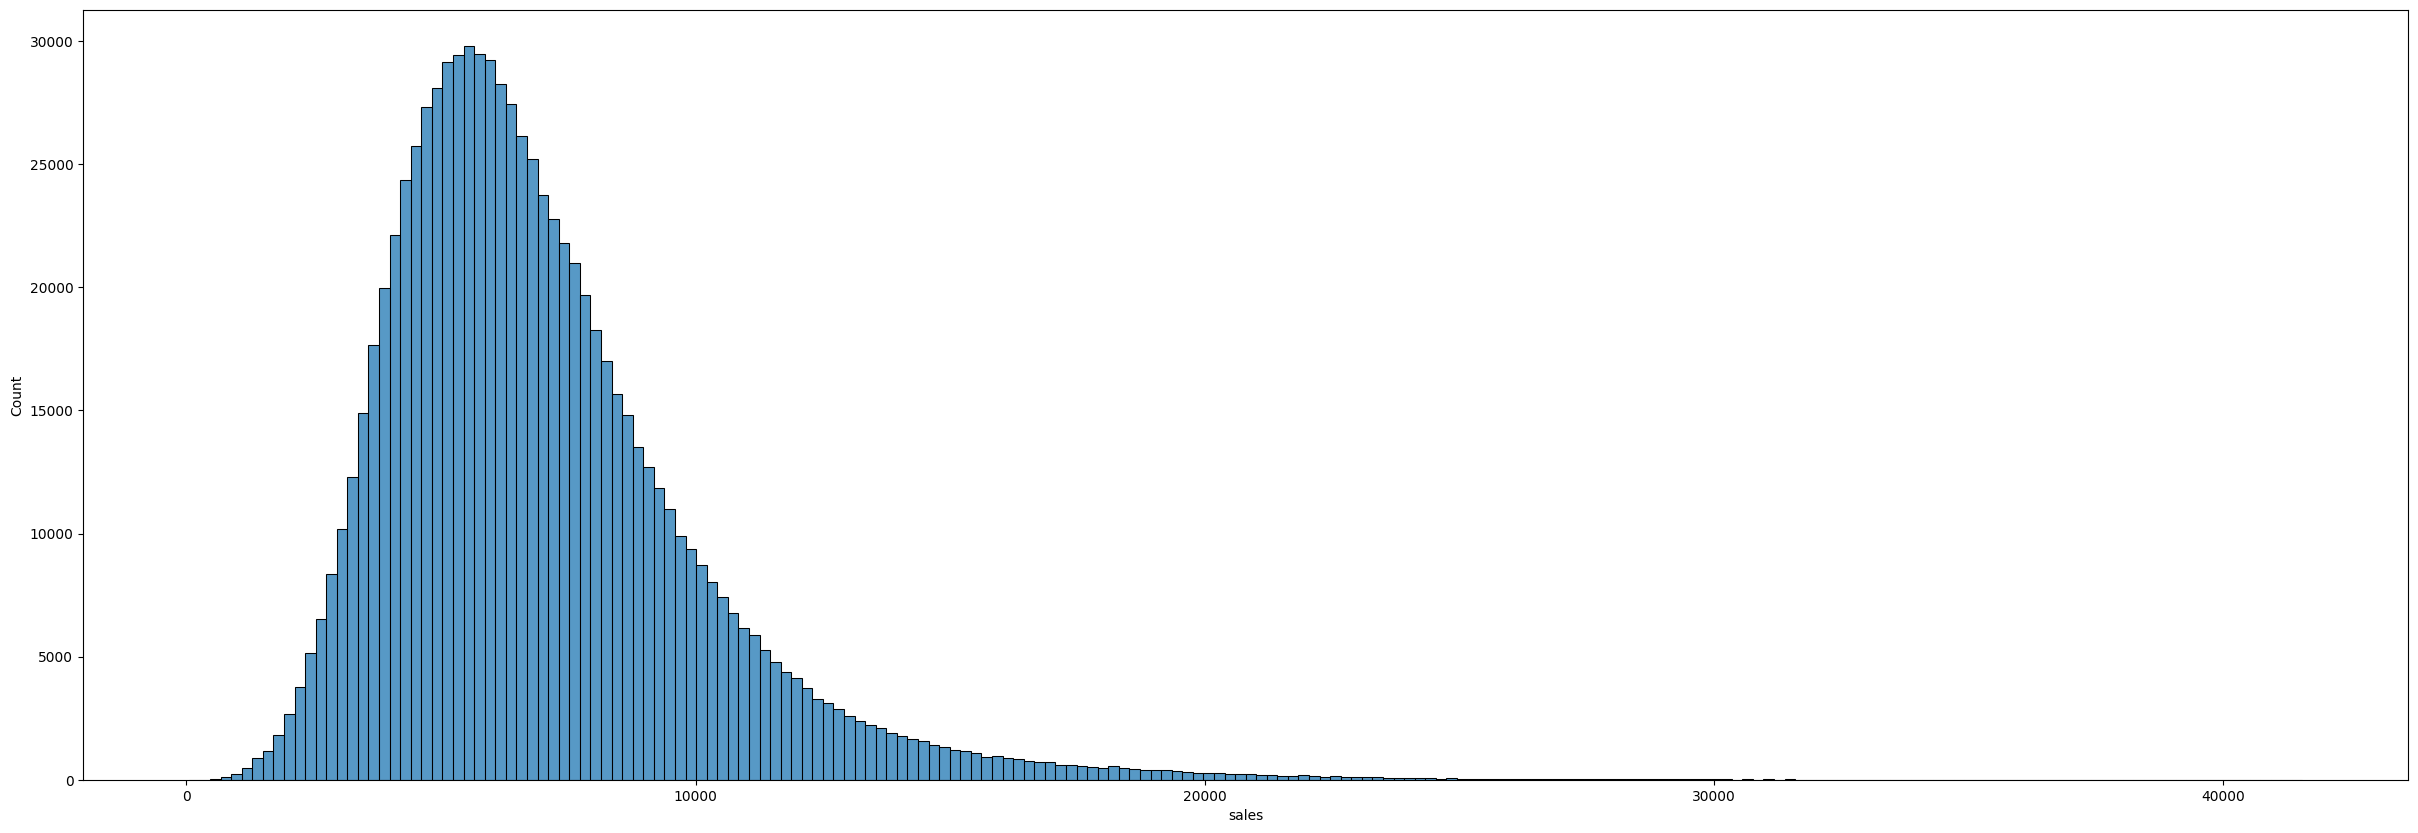

In [11]:
# Plotando a variável resposta 'sales' agruparas por faixas de cpntagem de vendas no dia por loja.
plt.figure(figsize=(30, 10))
sns.histplot( df_04['sales'], bins=200)

### 4.1.2. Variáveis numéricas

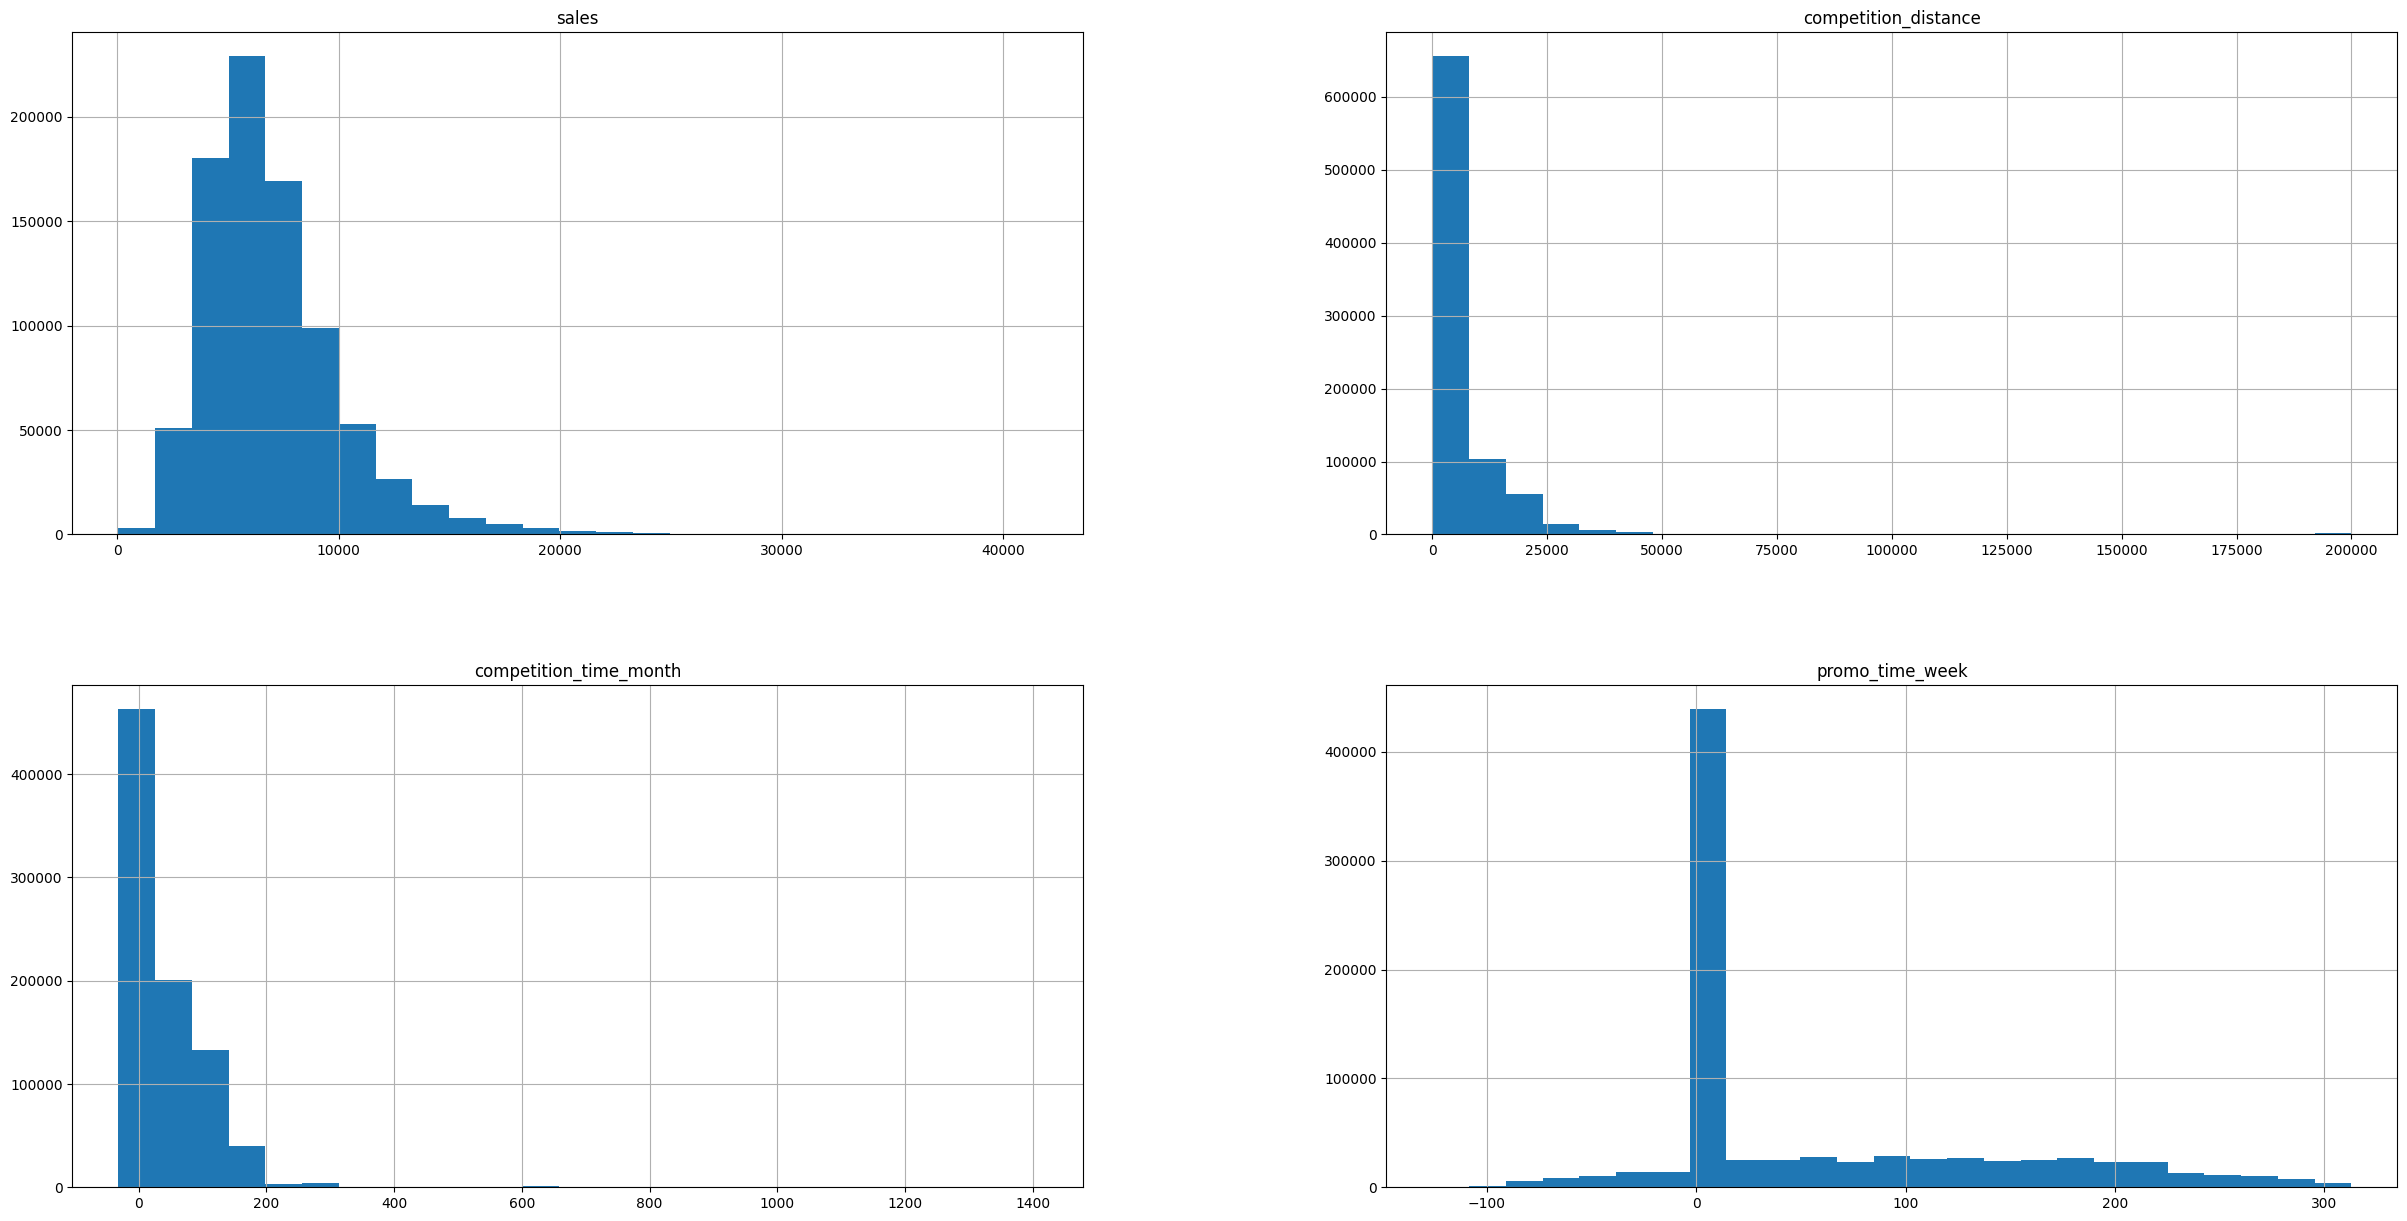

In [12]:
# Plotando variáveis numéricas:
plt.rcParams['figure.figsize'] = [30, 15]
attributes_numeric.hist( bins=25 );

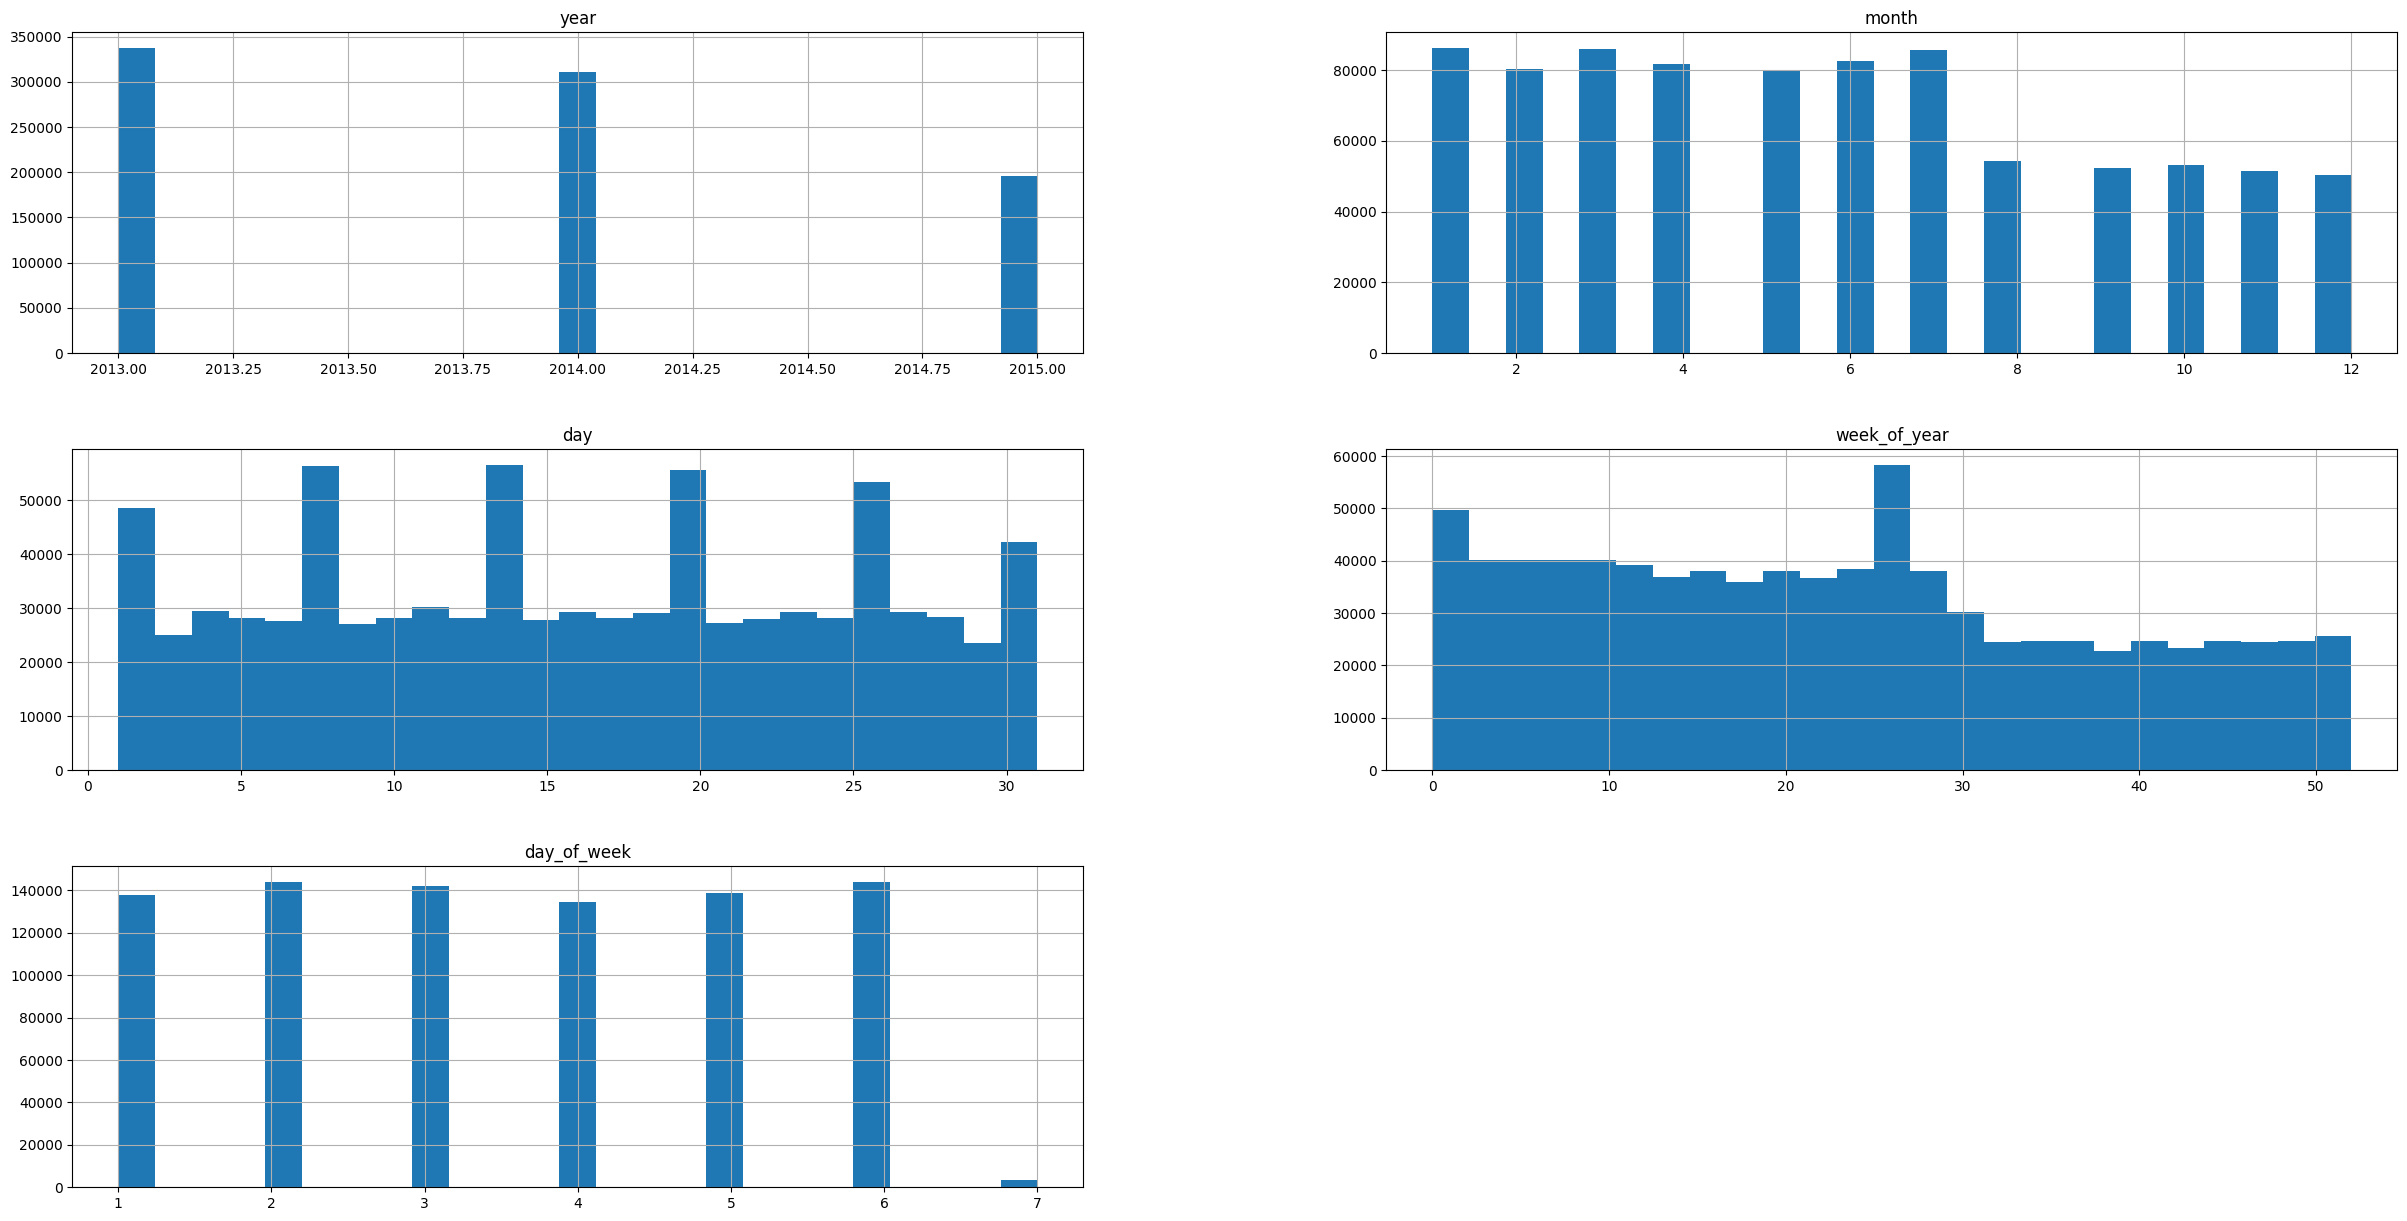

In [13]:
# Plotando variáveis temporais:
plt.rcParams['figure.figsize'] = [30, 15]
atributes_temporal.hist( bins=25 );

### 4.1.3. Variáveis categóricas

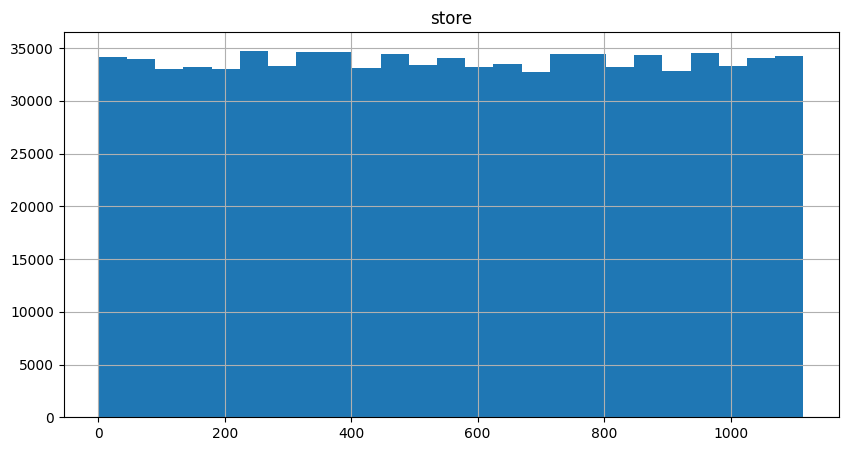

In [14]:
# Plotando variáveis identificadoras:
plt.rcParams['figure.figsize'] = [10, 5]
attributes_categorical_id.hist( bins=25 );

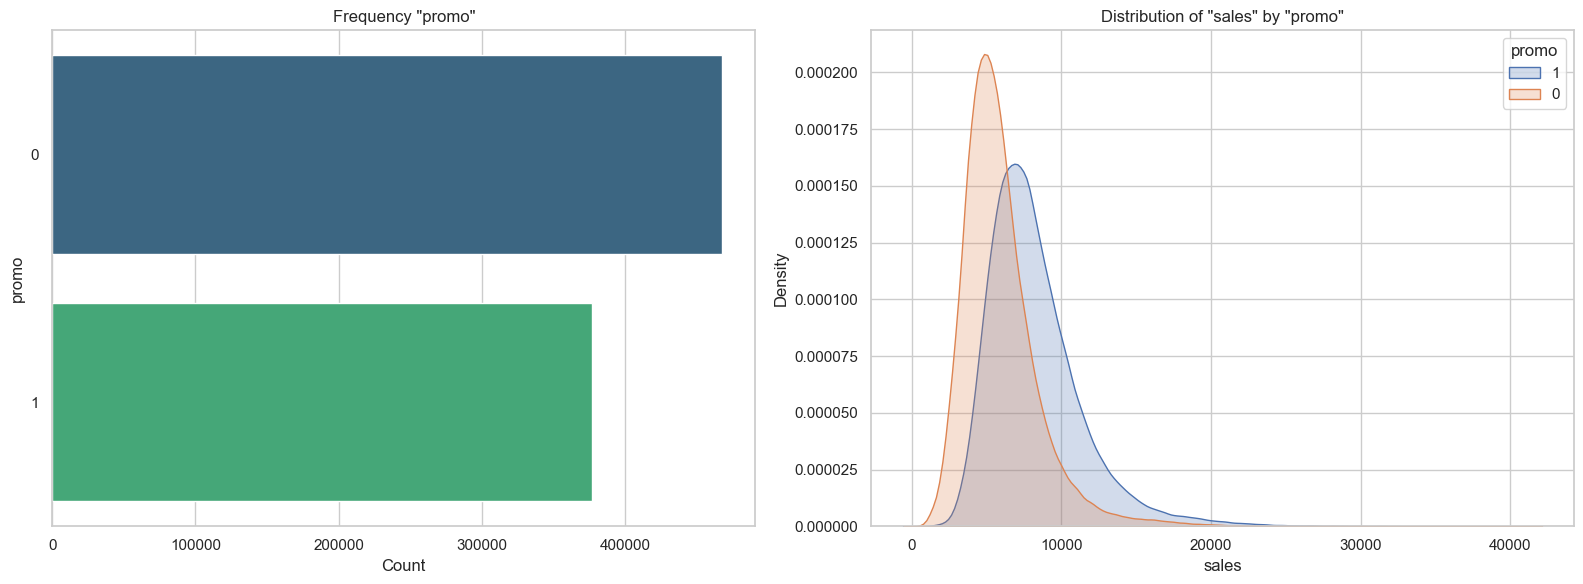

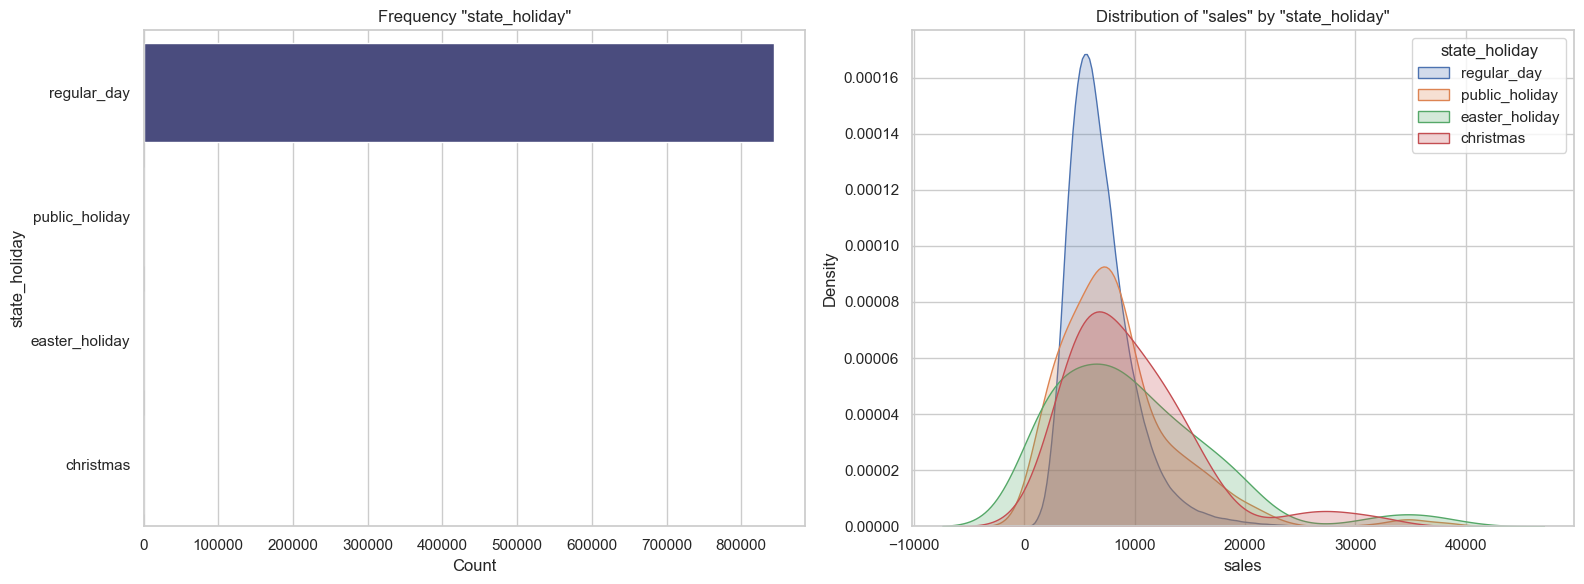

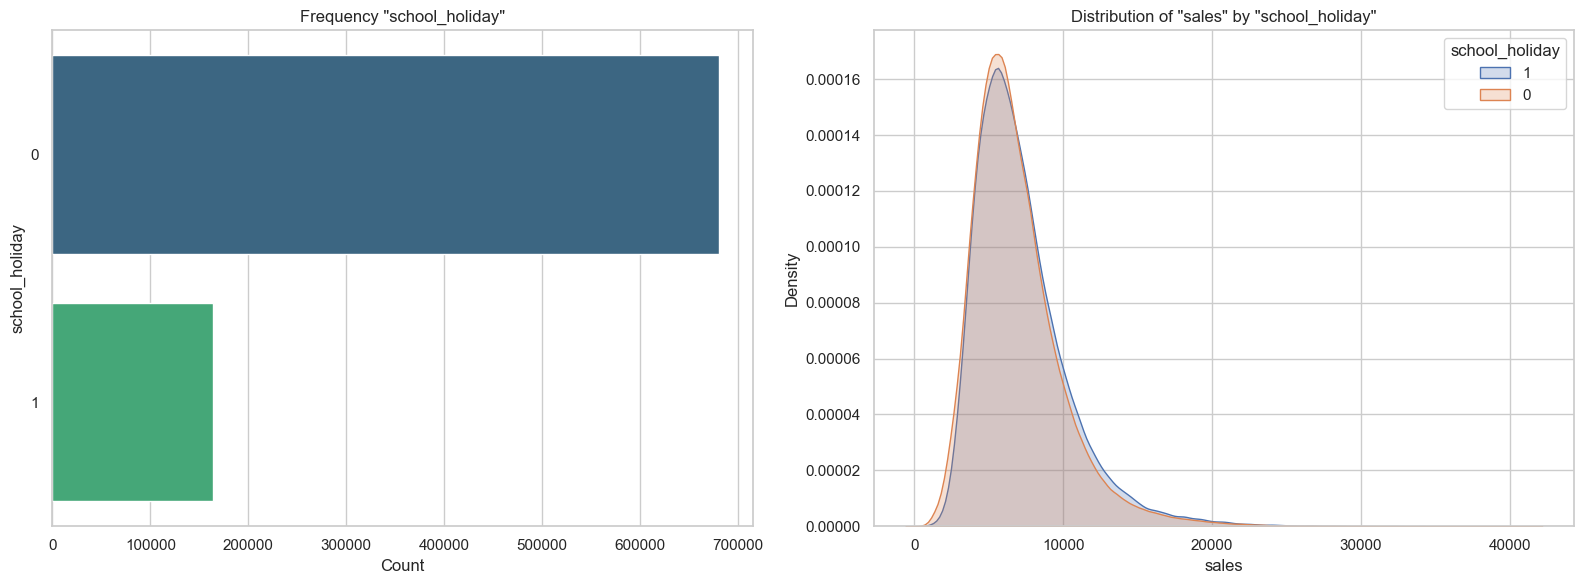

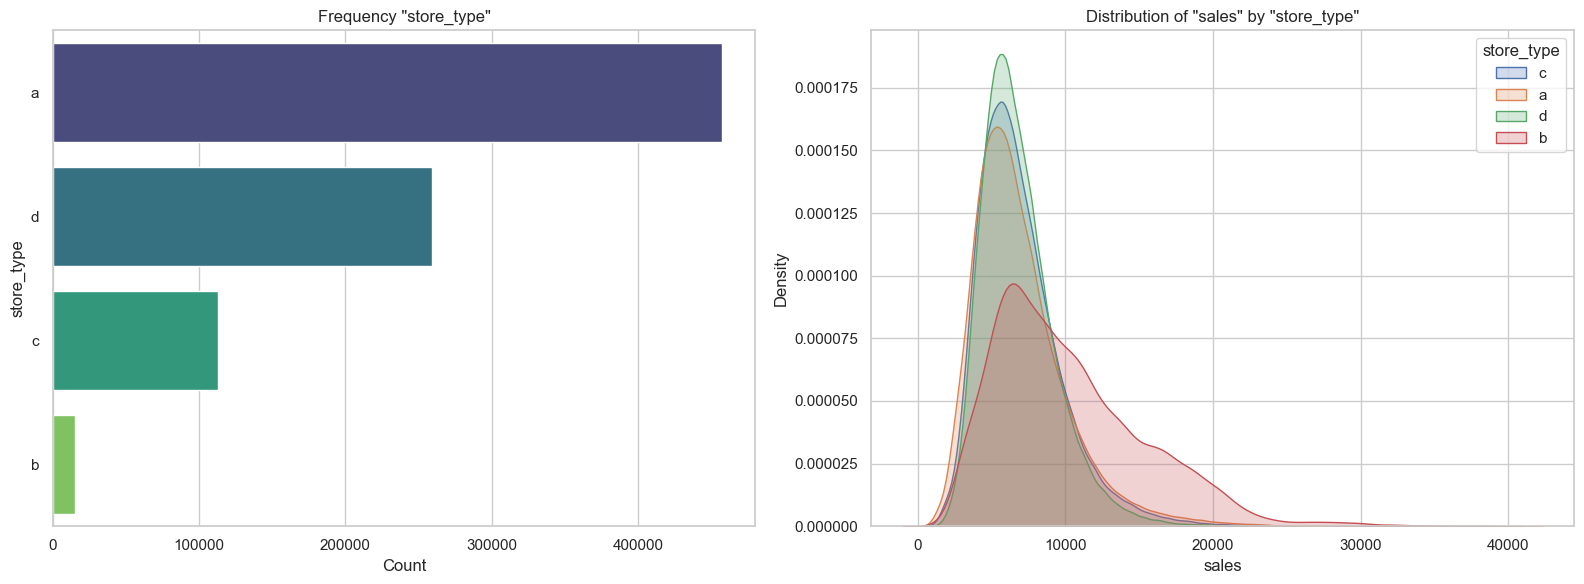

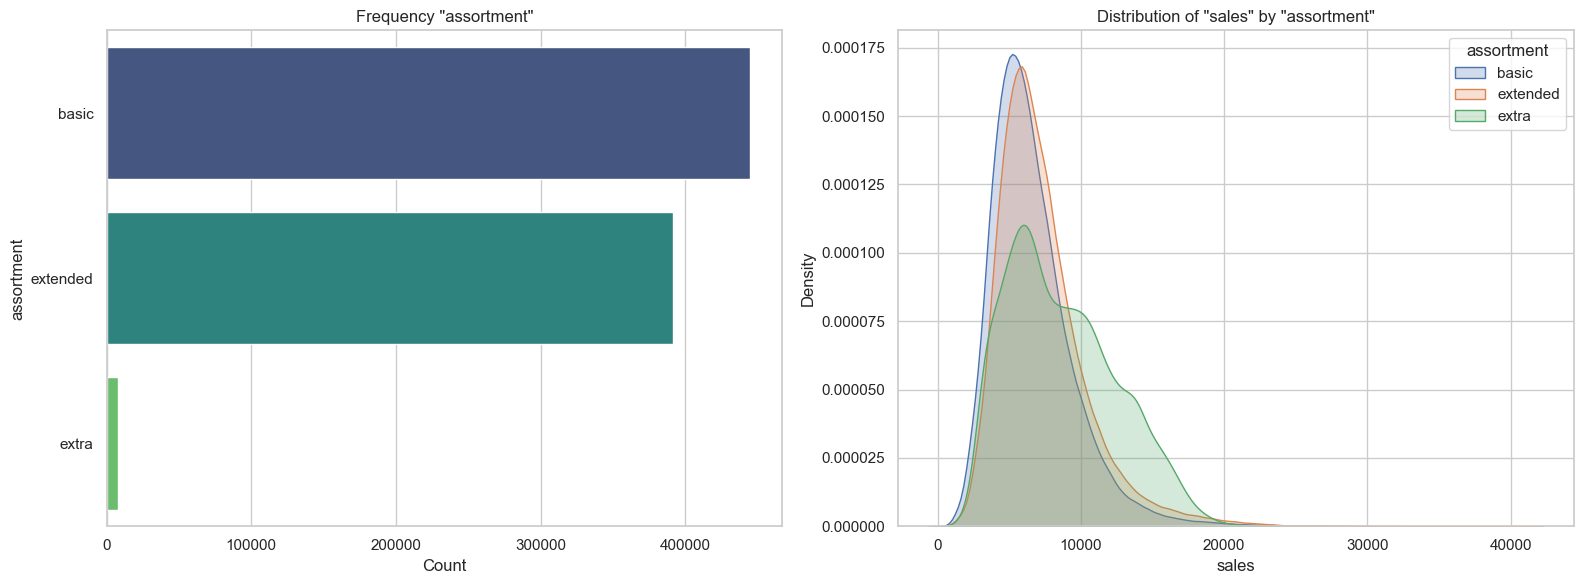

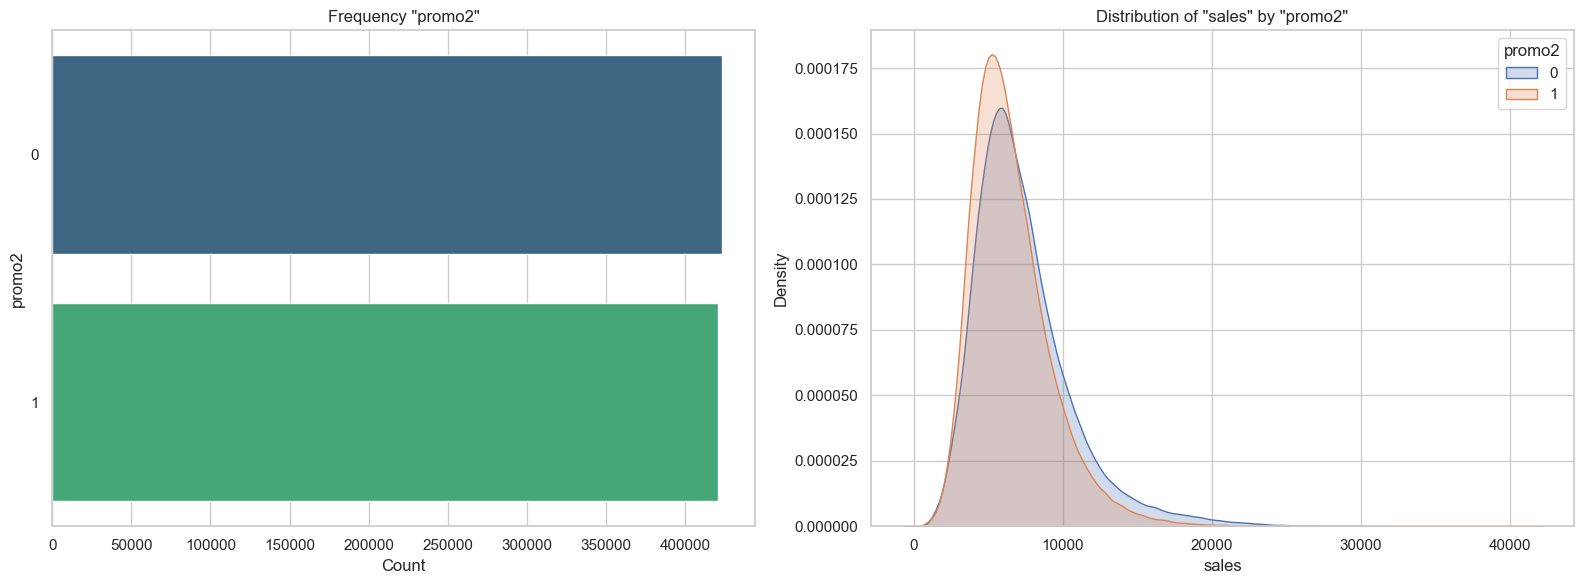

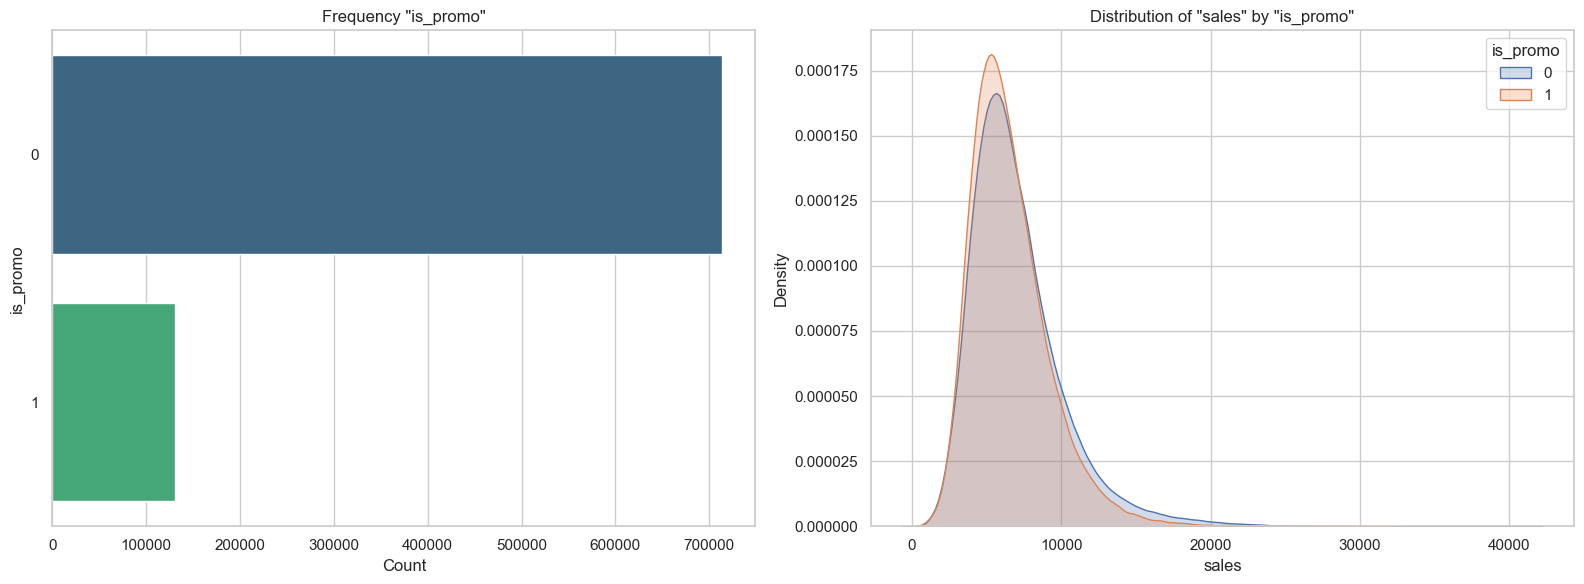

In [15]:
# Plotando variáveis categóricas:
for col in attributes_categorical:
    plot_categorical_distribution(df_04, col, 'sales')

## 4.2. Análise bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**VERDADEIRA** Lojas com **MAIOR SORTIMENTO** vendem **MAIS**.

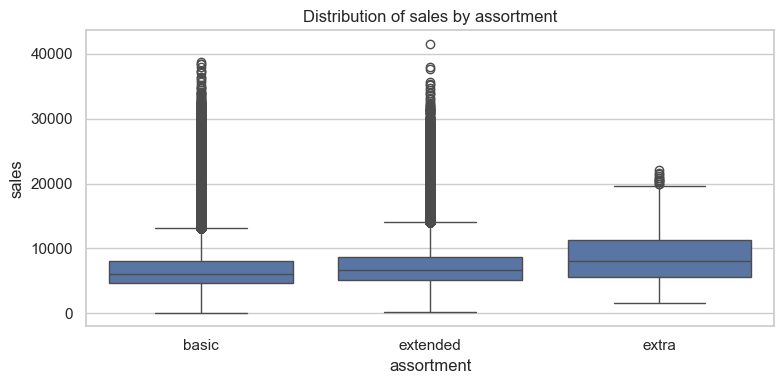

In [16]:
# Gerando um boxplot com a relação sales x assortment
plt.figure(figsize=(8, 4))
sns.boxplot(x='assortment', y='sales', data=df_04)

# Título e rótulos
plt.title('Distribution of sales by assortment')
plt.xlabel('assortment')
plt.ylabel('sales')

plt.tight_layout()
plt.show()

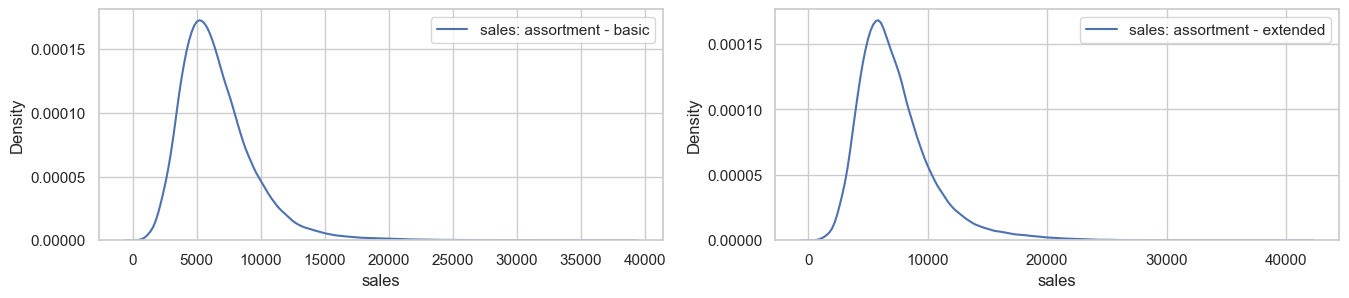

In [17]:
# Formato das distribuições
v1 = df_04.loc[df_04['assortment']=='basic','sales']
v2 = df_04.loc[df_04['assortment']=='extended','sales']

distribution_comparison(v1, v2, label_var_1='sales: assortment - basic', label_var_2='sales: assortment - extended')

In [18]:
# Verificação de diferença entre médias
average_coparison(v1, v2,distributon='normal_distributed' ,type='independent')

Variable 1 - Mean: 6621.52 +/- 2972.05
Variable 2 - Mean: 7300.84 +/- 3183.85
p-value: 0.0 -> Statistically significant difference
Test: Student t independent


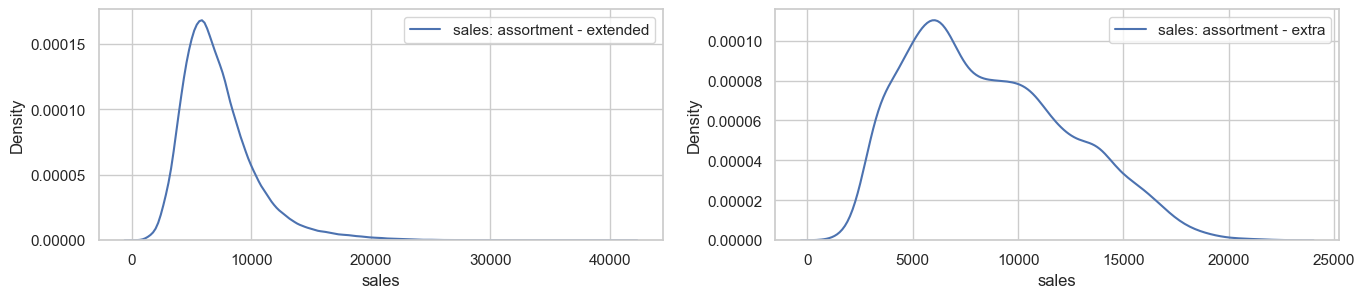

In [19]:
# Formato das distribuições
v1 = df_04.loc[df_04['assortment']=='extended','sales']
v2 = df_04.loc[df_04['assortment']=='extra','sales']

distribution_comparison(v1, v2, label_var_1='sales: assortment - extended', label_var_2='sales: assortment - extra')

In [20]:
# Verificação de diferença entre médias
average_coparison(v1, v2,distributon='non_normal_distributed' ,type='independent')

Variable 1 - Mean: 7300.84 +/- 3183.85
Variable 2 - Mean: 8642.5 +/- 3802.88
p-value: 0.0 -> Statistically significant difference
Test: Mann-Whitney U


### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** **NÃO HÁ CORRELAÇÃO** significativa entre as variáveis 'sales' e 'competition_distance'

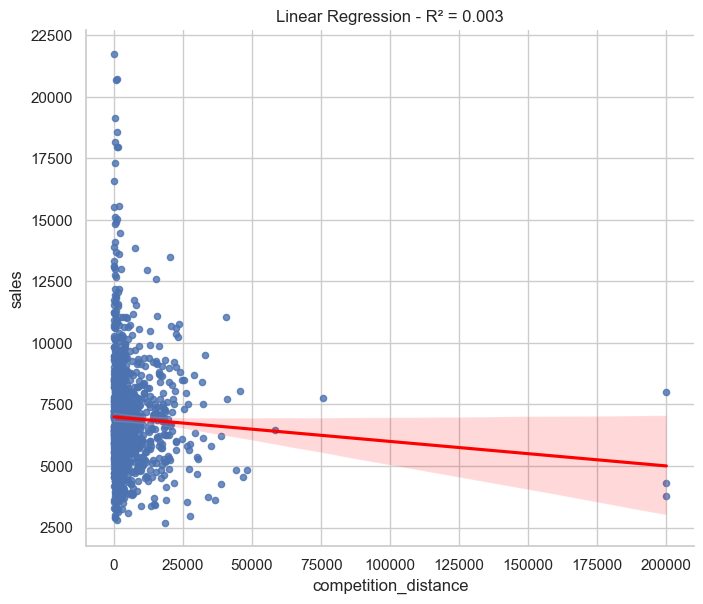

In [21]:
df_aux = df_04[['store', 'sales', 'competition_distance']]

df_aux = df_aux.groupby(by='store').mean().reset_index()

plot_linear_regression(df_aux['competition_distance'], df_aux['sales'])

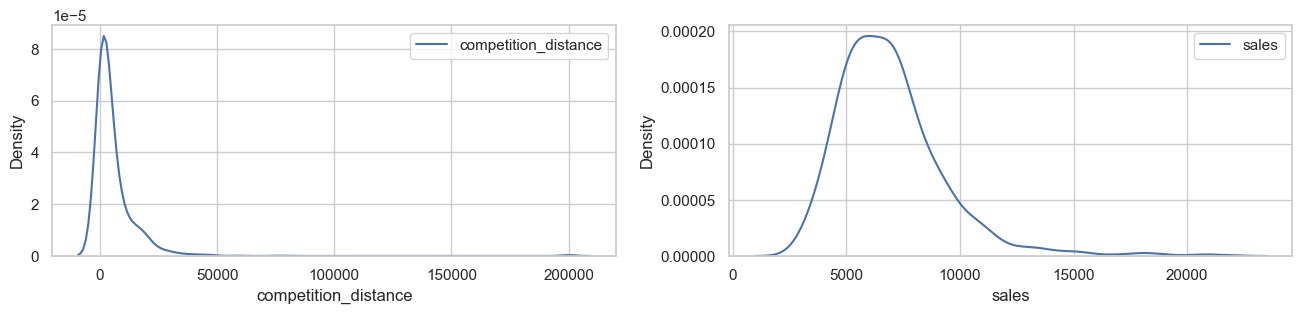

In [22]:
# Formato das distribuições
v1 = df_aux['competition_distance']
v2 = df_aux['sales']

distribution_comparison(v1, v2, label_var_1='competition_distance', label_var_2='sales')

In [23]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='normal_distributed', rounding=3)

Correlation = -0.053 -> Negligible
p-value = 0.078 - > Correlation is NOT statistically significant
Test: Pearson Correlation + Student t


### H3. Lojas com competidores a mais tempo deveriam vendem mais.

**FALSA** **NÃO HÁ CORRELAÇÃO** significativa entre as variáveis 'sales' e 'competition_time_month'

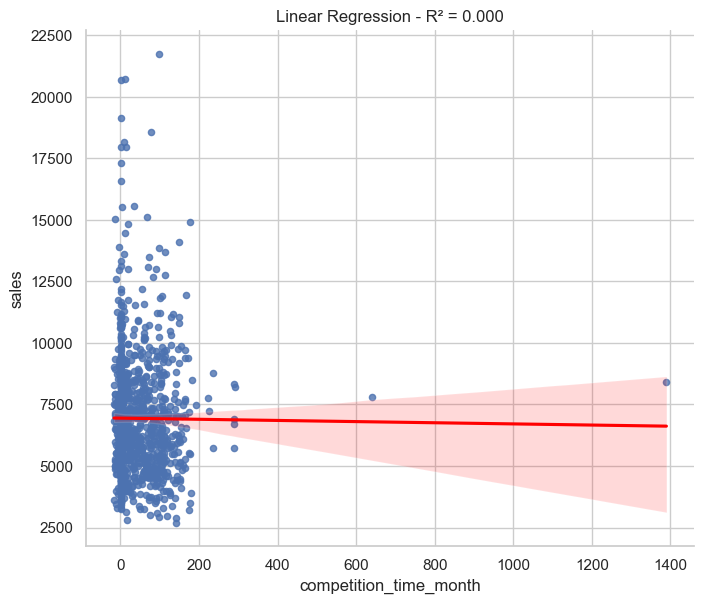

In [24]:
df_aux = df_04[['store', 'sales', 'competition_time_month']]

df_aux = df_aux.groupby(by='store').mean().reset_index()

plot_linear_regression(df_aux['competition_time_month'], df_aux['sales'])

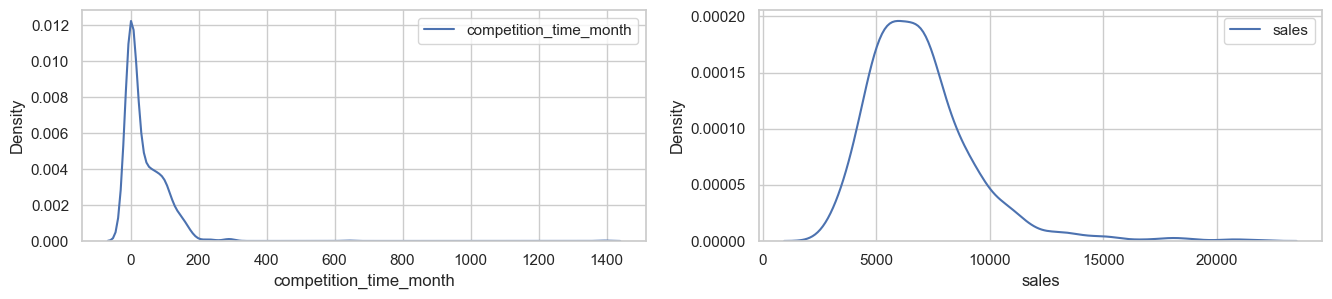

In [25]:
# Formato das distribuições
v1 = df_aux['competition_time_month']
v2 = df_aux['sales']

distribution_comparison(v1, v2, label_var_1='competition_time_month', label_var_2='sales')

In [26]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = -0.049 -> Negligible
p-value = 0.101 - > Correlation is NOT statistically significant
Test: Spearman Correlation + Distributed Ranks


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** **NÃO HÁ CORRELAÇÃO** significativa entre as variáveis 'sales' e 'promo_time_week'

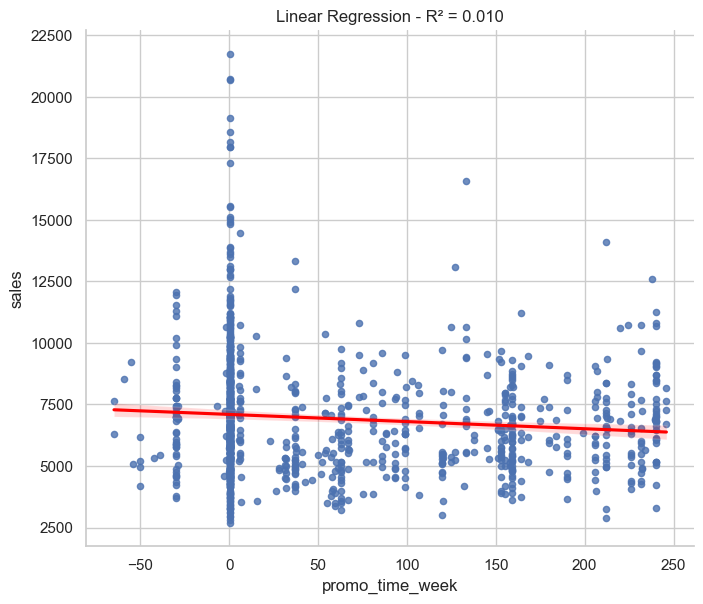

In [27]:
df_aux = df_04[['store', 'sales', 'promo_time_week']]

df_aux = df_aux.groupby(by='store').mean().reset_index()

plot_linear_regression(df_aux['promo_time_week'], df_aux['sales'])

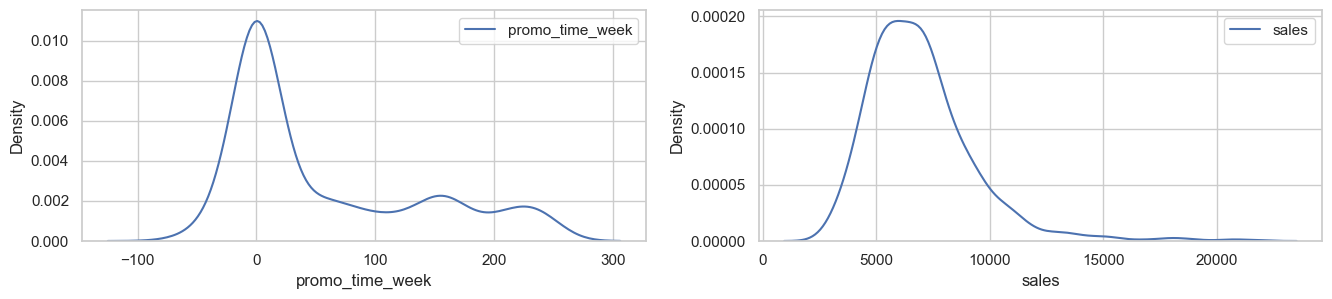

In [28]:
# Formato das distribuições
v1 = df_aux['promo_time_week']
v2 = df_aux['sales']

distribution_comparison(v1, v2, label_var_1='promo_time_week', label_var_2='sales')

In [29]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = -0.108 -> Negligible
p-value = 0.0 - > Correlation is statistically significant
Test: Spearman Correlation + Distributed Ranks


### H5. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com **MAIS** promoções consecutivas vendem **MENOS**

In [30]:
df_04[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().sort_values(by='sales').reset_index()

,promo,promo2,sales
0,0,1,5529.566684
1,0,0,6328.187633
2,1,1,7836.672987
3,1,0,8618.452062


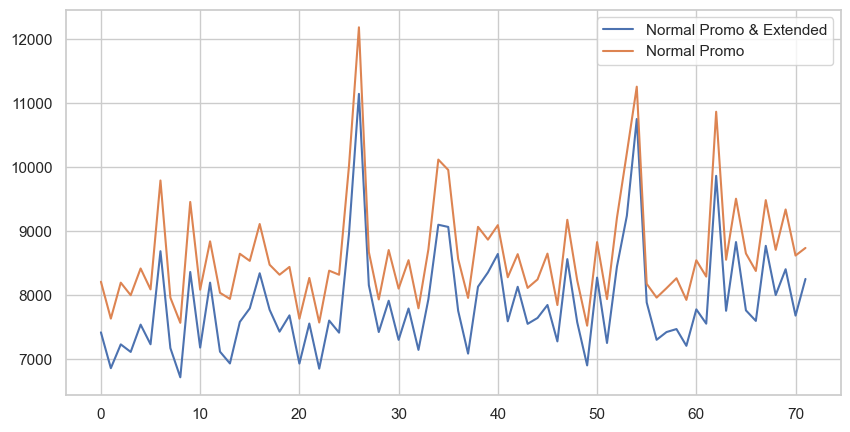

In [31]:
aux1 = df_04[( df_04['promo'] == 1 ) & ( df_04['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

aux2 = df_04[( df_04['promo'] == 1 ) & ( df_04['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Normal Promo & Extended', 'Normal Promo']);

### H6. Lojas abertas durante o feriado de Natal deveriam vender mais.

**VERDADEIRA** Lojas abertas durante o feriado do Natal vendem **MAIS**.

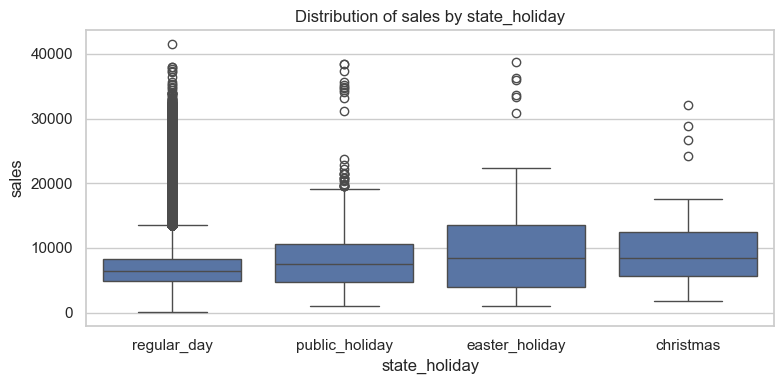

In [32]:
# Gerando um boxplot com a relação sales x state_holiday
plt.figure(figsize=(8, 4))
sns.boxplot(x='state_holiday', y='sales', data=df_04)

# Título e rótulos
plt.title('Distribution of sales by state_holiday')
plt.xlabel('state_holiday')
plt.ylabel('sales')

plt.tight_layout()
plt.show()

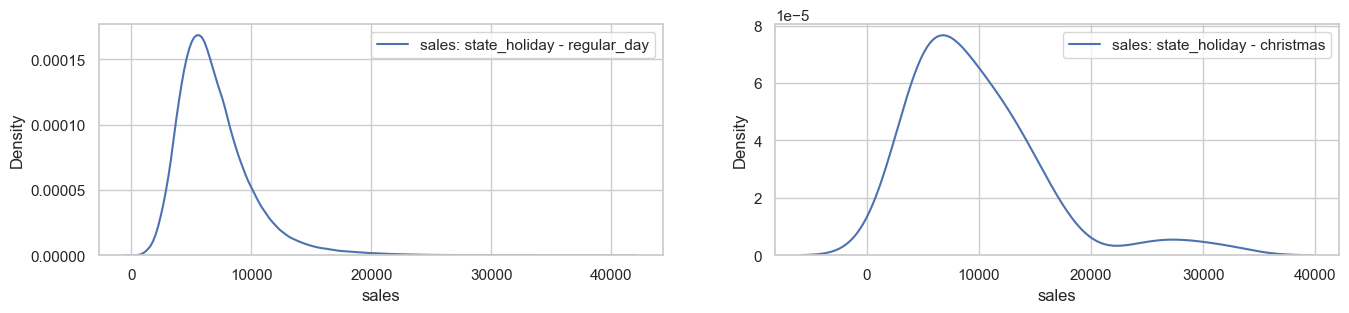

In [33]:
# Formato das distribuições
v1 = df_04.loc[df_04['state_holiday']=='regular_day','sales']
v2 = df_04.loc[df_04['state_holiday']=='christmas','sales']

distribution_comparison(v1, v2, label_var_1='sales: state_holiday - regular_day', label_var_2='sales: state_holiday - christmas')

In [34]:
# Verificação de diferença entre médias
average_coparison(v1, v2,distributon='non_normal_distributed' ,type='independent')

Variable 1 - Mean: 6953.96 +/- 3098.47
Variable 2 - Mean: 9743.75 +/- 5938.59
p-value: 0.0 -> Statistically significant difference
Test: Mann-Whitney U


### H7. Lojas deveriam vender mais ao longo dos anos.

**VERDADEIRA** Lojas vendem **MAIS** ao longo dos anos porém essa correlação é bastante fraca se considerarmos as lojas individualmente, mas do ponto de vista da rede completa é algo que pode ser afirmado com segurança.

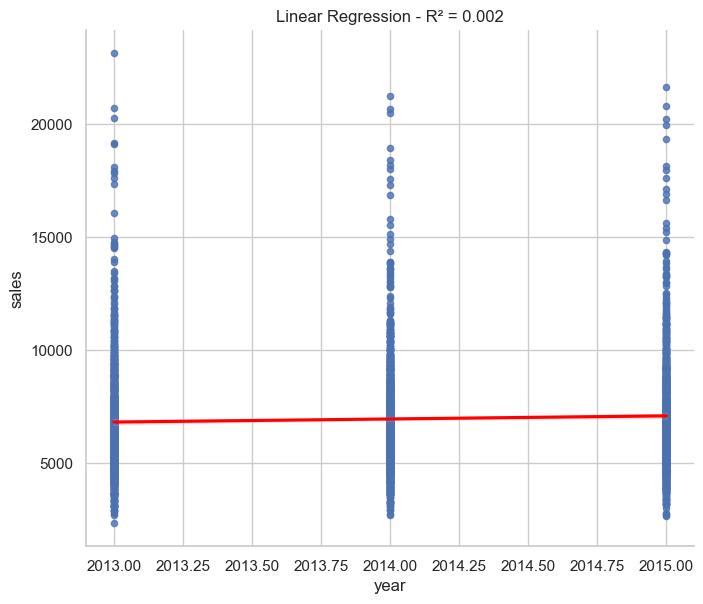

In [35]:
df_aux = df_04[['store', 'sales', 'year']]

df_aux = df_aux.groupby(by=['year', 'store']).mean().reset_index()

plot_linear_regression(df_aux['year'], df_aux['sales'])

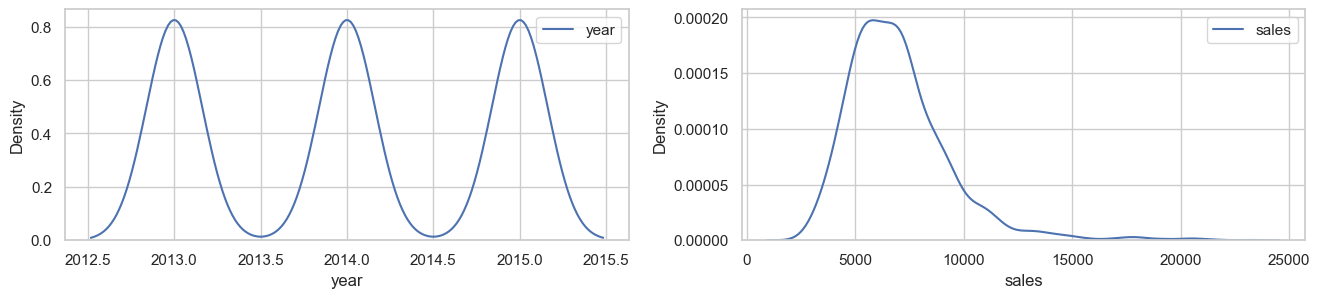

In [36]:
# Formato das distribuições
v1 = df_aux['year']
v2 = df_aux['sales']

distribution_comparison(v1, v2, label_var_1='year', label_var_2='sales')

In [37]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = 0.057 -> Negligible
p-value = 0.001 - > Correlation is statistically significant
Test: Spearman Correlation + Distributed Ranks


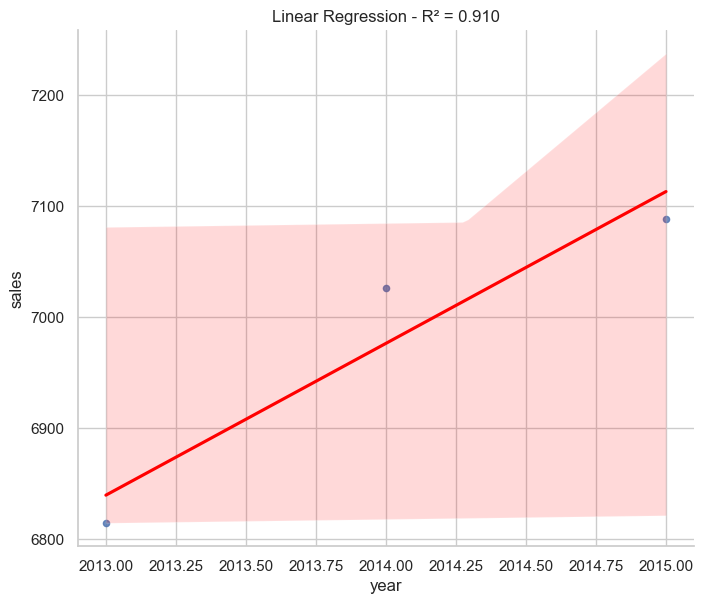

In [38]:
# Agrupando apenas pelos anos (panorama geral da rede)

df_aux = df_04[['sales', 'year']]

df_aux = df_aux.groupby(by=['year']).mean().reset_index()

plot_linear_regression(df_aux['year'], df_aux['sales'])

In [39]:
v1 = df_aux['year']
v2 = df_aux['sales']

In [40]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = 1.0 -> Very Strong
p-value = 0.0 - > Correlation is statistically significant
Test: Spearman Correlation + Distributed Ranks


### H8. Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Lojas vendem **MAIS** ao no segundo semestre porém essa correlação é bastante fraca se considerarmos as lojas individualmente, mas do ponto de vista da rede completa há uma correlação um pouco mais forte, porém sem significância estatística.

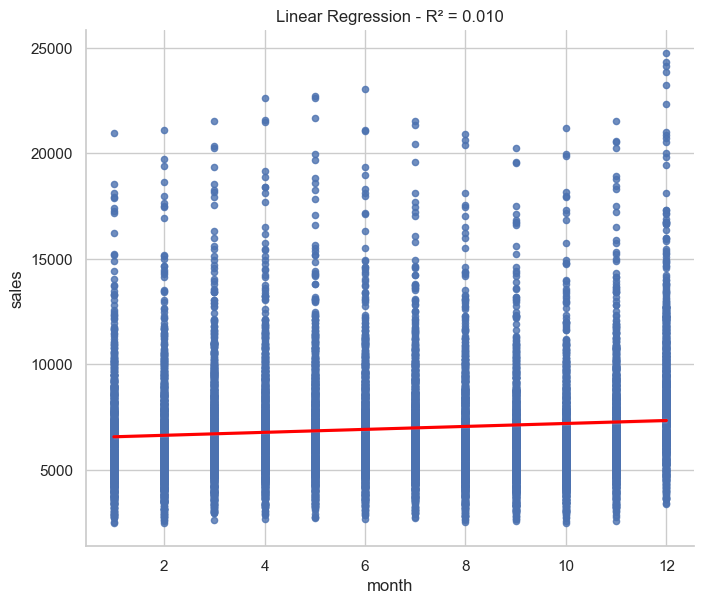

In [41]:
df_aux = df_04[['store', 'sales', 'month']]

df_aux = df_aux.groupby(by=['month', 'store']).mean().reset_index()

plot_linear_regression(df_aux['month'], df_aux['sales'])

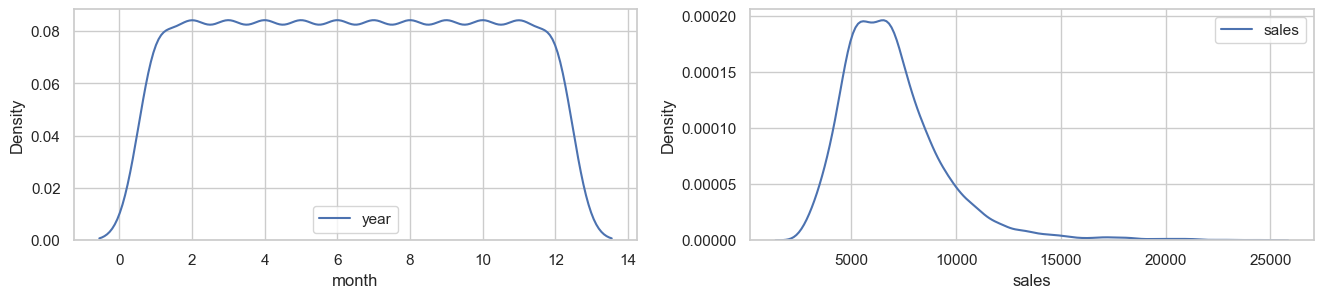

In [42]:
# Formato das distribuições
v1 = df_aux['month']
v2 = df_aux['sales']

distribution_comparison(v1, v2, label_var_1='year', label_var_2='sales')

In [43]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = 0.096 -> Negligible
p-value = 0.0 - > Correlation is statistically significant
Test: Spearman Correlation + Distributed Ranks


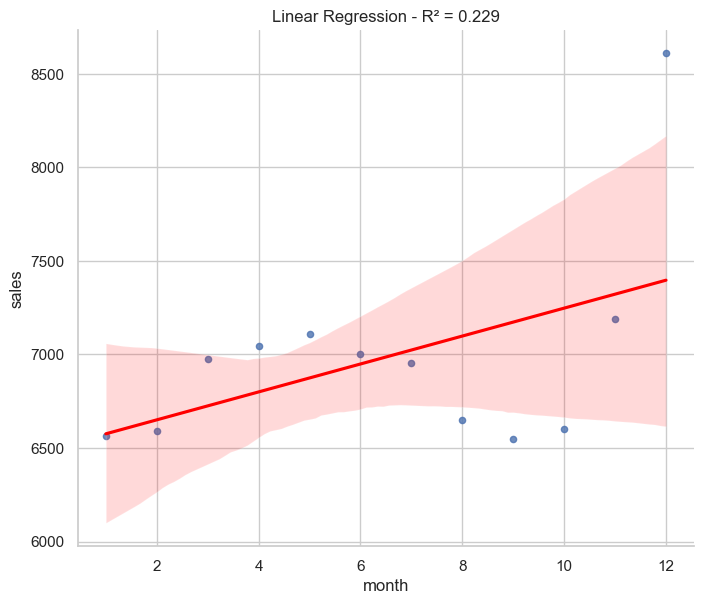

In [44]:
# Agrupando apenas pelos meses (panorama geral da rede)

df_aux = df_04[['sales', 'month']]

df_aux = df_aux.groupby(by=['month']).mean().reset_index()

plot_linear_regression(df_aux['month'], df_aux['sales'])

In [45]:
v1 = df_aux['month']
v2 = df_aux['sales']

In [46]:
# Teste de correlação
numeric_correlation_test(x=v1, y=v2, type='non_normal_distributed', rounding=3)

Correlation = 0.364 -> Week
p-value = 0.245 - > Correlation is NOT statistically significant
Test: Spearman Correlation + Distributed Ranks


### H9. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem **MENOS** nos final de semana

In [47]:
df_aux = df_04[['store', 'sales', 'day_of_week']]

df_aux = df_aux.groupby(by=['day_of_week', 'store']).mean().reset_index()

df_aux['weekend'] = df_aux.apply( lambda x: 1 if x['day_of_week']==6 or x['day_of_week']==7 else 0, axis=1)

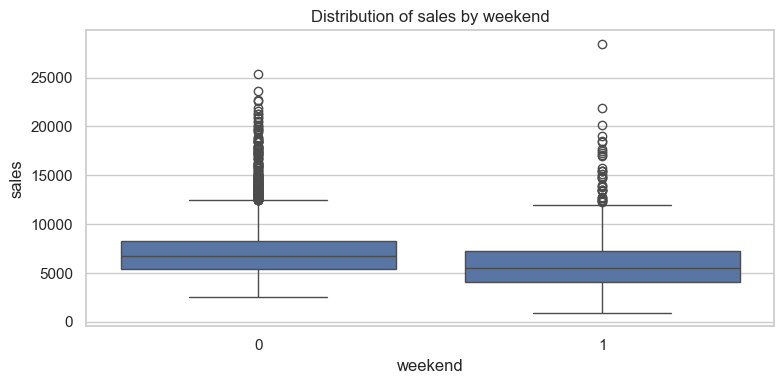

In [48]:
# Gerando um boxplot com a relação sales x weekend
plt.figure(figsize=(8, 4))
sns.boxplot(x='weekend', y='sales', data=df_aux)

# Título e rótulos
plt.title('Distribution of sales by weekend')
plt.xlabel('weekend')
plt.ylabel('sales')

plt.tight_layout()
plt.show()

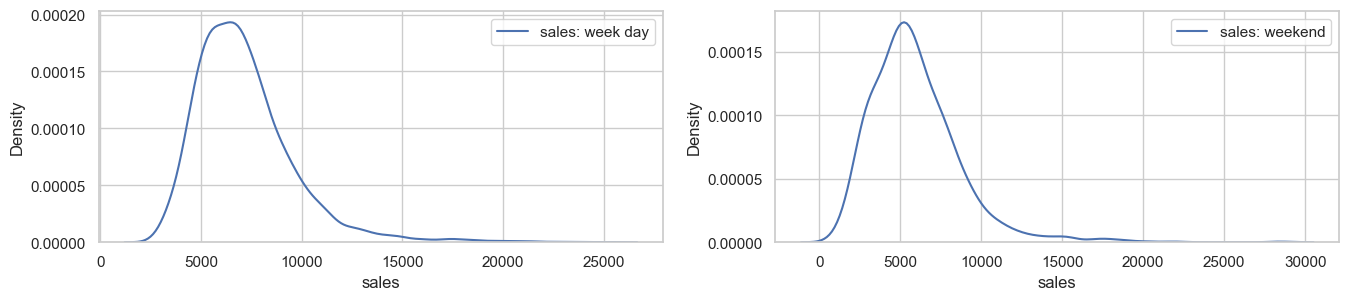

In [49]:
# Formato das distribuições
v1 = df_aux.loc[df_aux['weekend']==0,'sales']
v2 = df_aux.loc[df_aux['weekend']==1,'sales']

distribution_comparison(v1, v2, label_var_1='sales: week day', label_var_2='sales: weekend')

In [50]:
# Verificação de diferença entre médias
average_coparison(v1, v2,distributon='normal_distributed' ,type='independent')

Variable 1 - Mean: 7155.22 +/- 2491.02
Variable 2 - Mean: 5928.25 +/- 2802.04
p-value: 0.0 -> Statistically significant difference
Test: Student t independent


### H10. Lojas deveriam vender menos durante os feriados escolares.

**FALSA** Lojas vendem **MAIS** durante os feriados escolares.

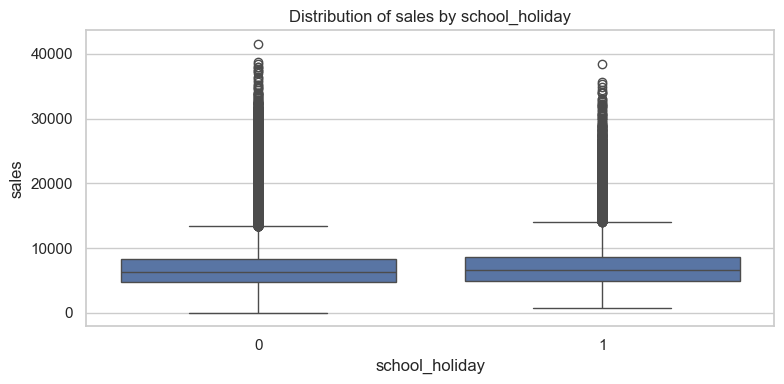

In [51]:
# Gerando um boxplot com a relação sales x school_holiday
plt.figure(figsize=(8, 4))
sns.boxplot(x='school_holiday', y='sales', data=df_04)

# Título e rótulos
plt.title('Distribution of sales by school_holiday')
plt.xlabel('school_holiday')
plt.ylabel('sales')

plt.tight_layout()
plt.show()

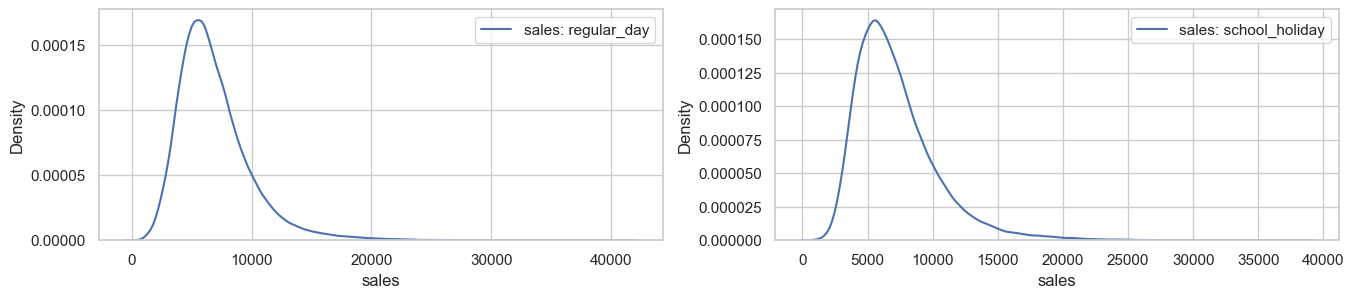

In [52]:
# Formato das distribuições
v1 = df_04.loc[df_04['school_holiday']==0,'sales']
v2 = df_04.loc[df_04['school_holiday']==1,'sales']

distribution_comparison(v1, v2, label_var_1='sales: regular_day', label_var_2='sales: school_holiday')

In [53]:
# Verificação de diferença entre médias
average_coparison(v1, v2,distributon='normal_distributed' ,type='independent')

Variable 1 - Mean: 6897.21 +/- 3083.39
Variable 2 - Mean: 7200.71 +/- 3175.81
p-value: 0.0 -> Statistically significant difference
Test: Student t independent


## 4.3. Análise multivariada

### 4.3.1. Variáveis numéricas

In [54]:
# Selecionando variáveis contínuas (numéricas) adicionando as temporais:
attributes_numeric = df_04[['sales', 
                            'competition_distance', 
                            'competition_time_month',
                            'promo_time_week',
                            'year',
                            'month',
                            'day',
                            'week_of_year',
                            'day_of_week'
                            ]]

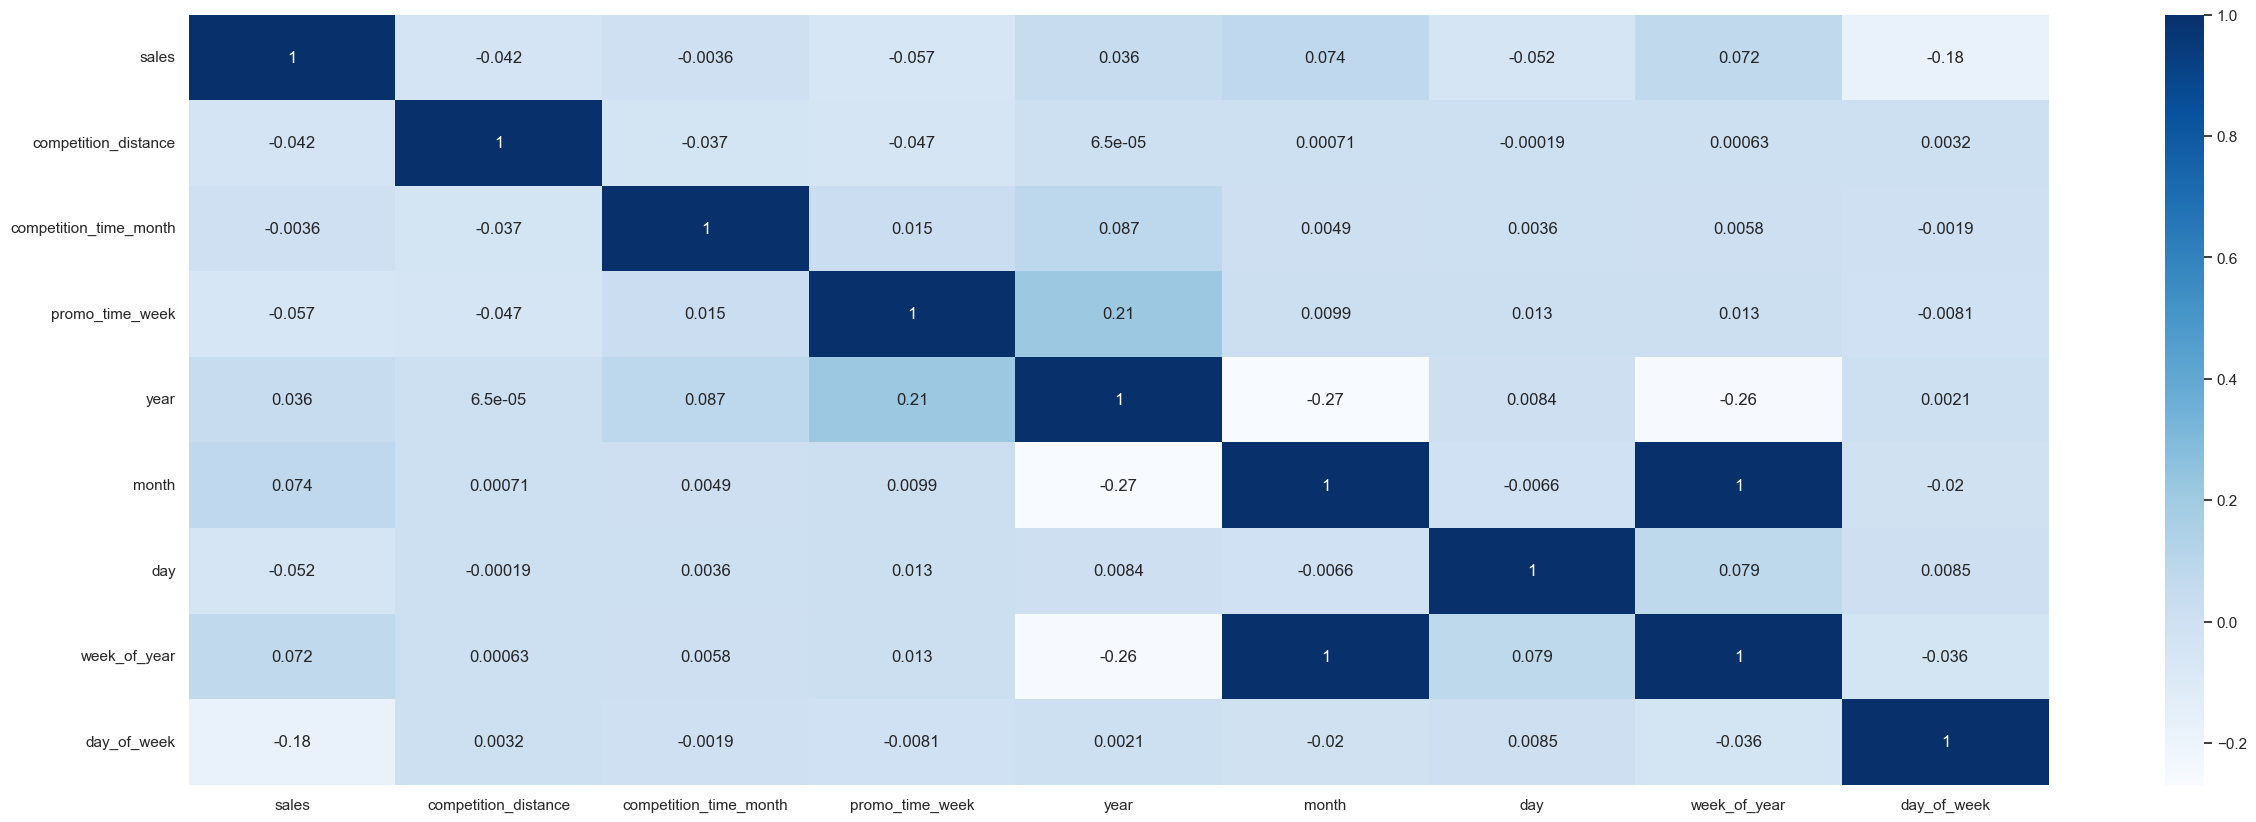

In [55]:
correlation = attributes_numeric.corr( method='pearson' )
plt.figure(figsize=(30, 10))
sns.heatmap( correlation, annot=True, cmap='Blues' );

### 4.3.2. Variáveis categóricas

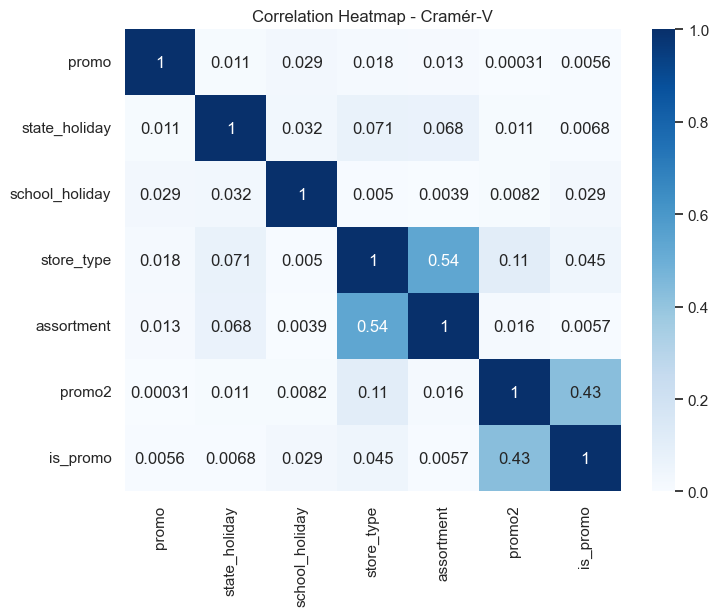

In [56]:
# Selecionar apenas as variáveis categóricas
cat_cols = attributes_categorical.columns

# Calcular matriz de V de Cramér
matriz_v = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                        index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        matriz_v.loc[col1, col2] = cramer_v(attributes_categorical[col1], attributes_categorical[col2])

# Plotar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_v, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title("Correlation Heatmap - Cramér-V")
plt.show()

## 4.4. Relatório Geral

Geração de um relatório no ProfileReport do pacote ydata_profiling. O arquivo html gerado pode ser visualizado no endereço *exports/reports/relatorio_dados_04.html*.

In [57]:
#profile = ProfileReport(df_04, title="Relatório de Análise", explorative=True)
#profile.to_file("../exports/reports/relatorio_dados_04.html")

**Estudo de sazonalidade (semanal)**

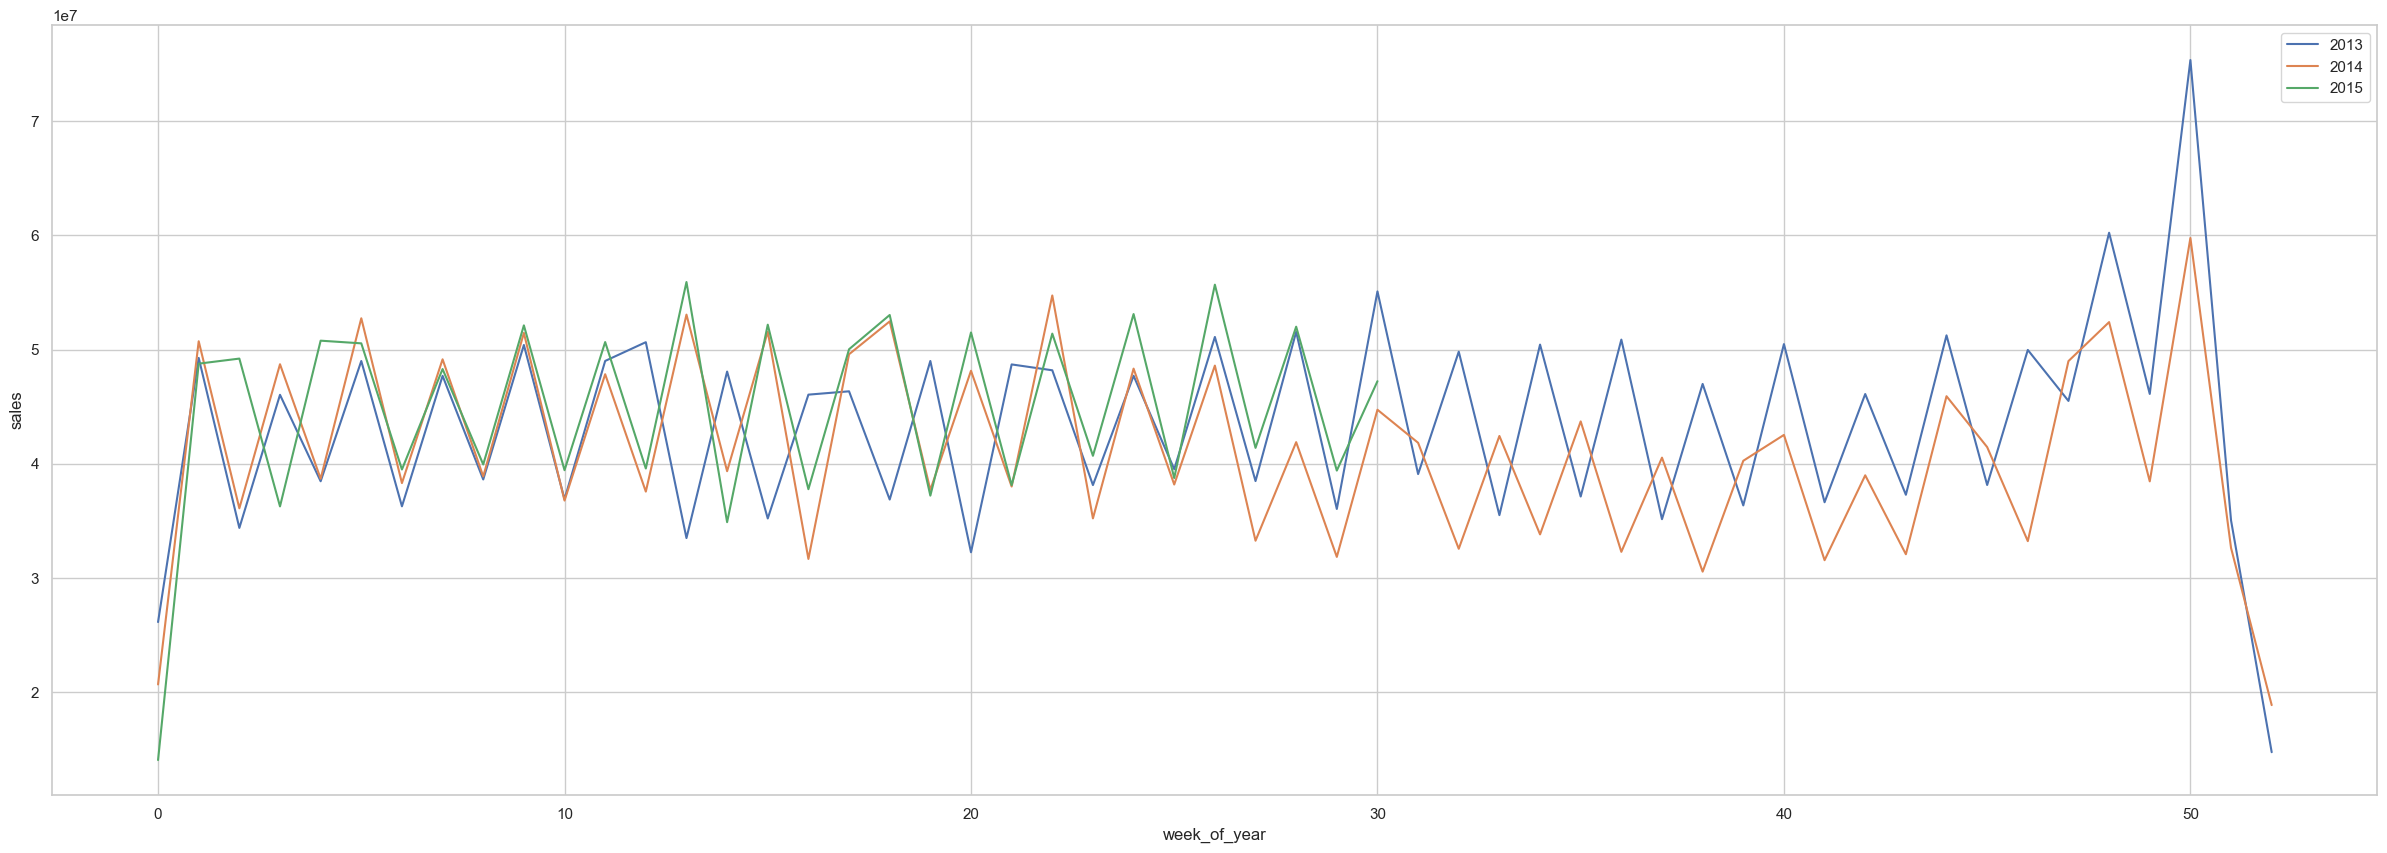

In [58]:
df_aux = df_04.loc[:,['year', 'week_of_year', 'sales']].groupby(['year', 'week_of_year']).sum().sort_values(by=['year', 'week_of_year'], ascending=True).reset_index()

plt.figure(figsize=(30, 10))
for year in range(2013, 2016):
    sns.lineplot(x=df_aux.loc[df_aux['year']==year,'week_of_year'], y=df_aux['sales'], label=year)
    plt.legend()